# Maximum Likelihood Neural Regression

In [1]:
#Modulees

#jax
from jax import jacfwd, vmap
import jax.numpy as jnp
import jax.random as jrandom

#haiku
import haiku as hk

#os
import os

import pandas as pd

#numpy
import numpy as np

import pickle

#matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as tkr

#other modules
from load_manifold import get_generator_dim, load_manifold

#scores
from models import neural_regression
from models import models

#jaxgeometry
from jaxgeometry.statistics.score_matching import model_loader
from jaxgeometry.autodiff import jacfwdx
from jaxgeometry.statistics.score_matching import ScoreEvaluation
from jaxgeometry.manifolds import *

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
2024-05-15 15:47:54.491258: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
#Hyper Parameters
T = 0.5
score_path = "scores"
s2_approx = 0
s1loss_type = "dsm"
s2loss_type = "dsm"
s2_type = "s1s2"
seed = 2712

figure_path = '../figures/ml_regression/'
if not os.path.exists(figure_path):
    os.makedirs(figure_path)

In [3]:
def get_coords(M, Fx):
    chart = M.centered_chart(Fx)
    return (M.invF((Fx,chart)),chart)

In [4]:
def load_mlnr_model(manifold, dim):
    M, x0, sampling_method, generator_dim, layers, opt_val = load_manifold(manifold, dim)
    layers_s1, layers_s2 = layers
    mlnr_path = f"mlnr/{manifold}{dim}/"
    if "Local" in sampling_method:
        method = "Local"
    else:
        method = "Embedded"
    
    if manifold == "Euclidean":
        @hk.transform
        def mlnr_model(x):

            mlnr =  neural_regression.MLP_mlnr_R2(
                neural_regression.MLP_f_R2(dim=generator_dim, layers=layers_s1), 
                neural_regression.MLP_sigma(layers=layers_s1)
                )

            return mlnr(x)
    else:
        @hk.transform
        def mlnr_model(x):

            mlnr =  neural_regression.MLP_mlnr_S2(
                neural_regression.MLP_f_S2(dim=generator_dim, layers=layers_s1), 
                neural_regression.MLP_sigma(layers=layers_s1)
                )

            return mlnr(x)

    rng_key = jrandom.PRNGKey(seed)
    mlnr_state = model_loader.load_model(mlnr_path)
    
    mlnr_fun = lambda x: mlnr_model.apply(mlnr_state.params, rng_key, x)
                       
    return M, x0, mlnr_fun

In [5]:
def load_data(manifold, dim):
    mlnr_path = f"mlnr/{manifold}{dim}/"
    if manifold == "Euclidean":
        input_data = pd.read_csv(''.join((mlnr_path, 'input.csv')), header=None)
        output_data = pd.read_csv(''.join((mlnr_path, 'output.csv')), header=None)
        
        return jnp.array(input_data.values), jnp.array(output_data.values)
    else:
        data_path = '../data/AFLW2000/head_pose.pkl'
        with open(data_path, 'rb') as f:
            data_dict = pickle.load(f)
            
        input_data = jnp.array(data_dict['features'])
        output_data = jnp.array(data_dict['labels'])
        
        return jnp.array(input_data), jnp.array(output_data)

In [6]:
def load_score_model(manifold, dim):
    M, x0, sampling_method, generator_dim, layers, opt_val = load_manifold(manifold, dim)
    if "Local" in sampling_method:
        method = "Local"
    else:
        method = "Embedded"
    
    s1p_path = ''.join((score_path, f"/{manifold}{dim}/s1p_{s1loss_type}/"))
    layers = get_generator_dim(manifold, generator_dim)[0]

    s1p_model = hk.transform(lambda x: models.MLP_p(dim=generator_dim, layers=layers)(x))
        
    s1p_state = model_loader.load_model(s1p_path)
    
    rng_key = jrandom.PRNGKey(seed)
    
    if method == "Local":
        s1p_fun = lambda x,y,t: s1p_model.apply(s1p_state.params, rng_key, jnp.hstack((x[0],y[0],t)))
    else:
        s1p_fun = lambda x,y,t: s1p_model.apply(s1p_state.params, rng_key, jnp.hstack((M.F(x),M.F(y),t)))
                       
    return M, x0, s1p_fun

## Testing with $\mathbb{R}^{2}$

In [7]:
M, x0, mlnr_fun = load_mlnr_model("Euclidean", 2)
input_data, output_data = load_data("Euclidean", 2)

using M.Exp for Logarithm


In [8]:
sorted_input = jnp.sort(input_data, axis=0)
f, sigma = mlnr_fun(sorted_input)

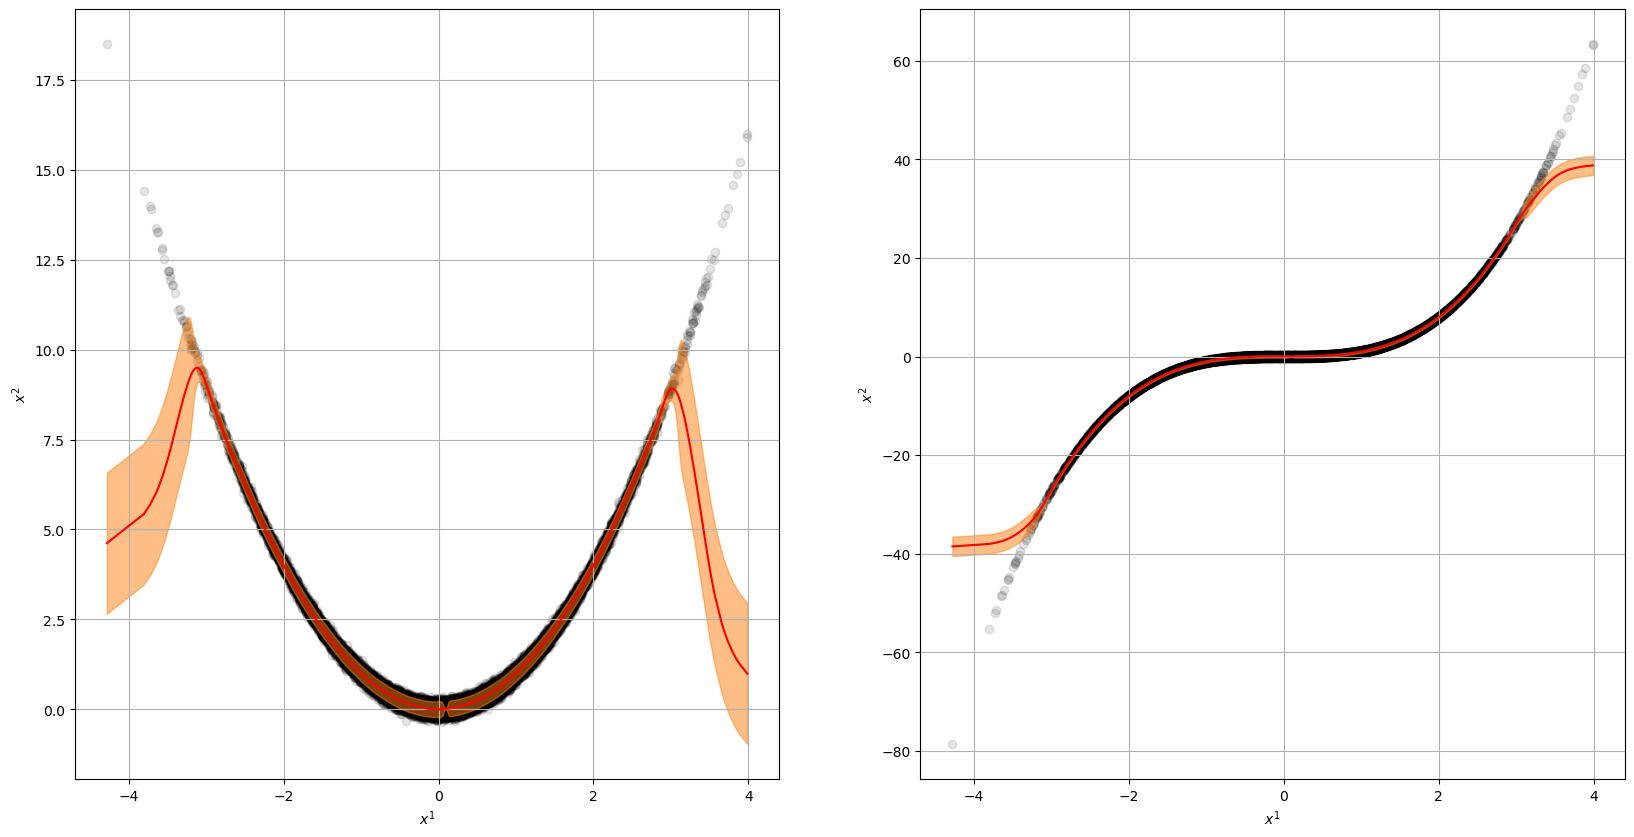

In [9]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(121)
ax.plot(sorted_input, f[:,0], color='red')
ax.scatter(input_data,output_data[:,0], color='black', alpha=0.1)
ax.fill_between(
    sorted_input.ravel(),
    f[:,0] - 1.96 * sigma,
    f[:,0] + 1.96 * sigma,
    color="tab:orange",
    alpha=0.5,
    label=r"95% confidence interval",
)
ax.grid(True)
ax.set_xlabel(r'$x^{1}$')
ax.set_ylabel(r'$x^{2}$')

ax = fig.add_subplot(122)
ax.plot(sorted_input, f[:,1], color='red')
ax.scatter(input_data,output_data[:,1], color='black', alpha=0.1)
ax.fill_between(
    sorted_input.ravel(),
    f[:,1] - 1.96 * sigma,
    f[:,1] + 1.96 * sigma,
    color="tab:orange",
    alpha=0.5,
    label=r"95% confidence interval",
)
ax.grid(True)
ax.set_xlabel(r'$x^{1}$')
ax.set_ylabel(r'$x^{2}$')

plt.show()


## Application to AFWL2000 Head Position Data

In [10]:
data_path = '../data/AFLW2000/head_pose.pkl'

In [11]:
with open(data_path, 'rb') as f:
    data_dict = pickle.load(f)

In [12]:
M, x0, mlnr_fun = load_mlnr_model("Sphere", 3)

using M.Exp for Logarithm


In [13]:
import cv2
def draw_axis(img, pitch,yaw,roll, tdx=None, tdy=None, size = 100):

    yaw = -yaw
    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # X-Axis pointing to right. drawn in red
    x1 = size * (jnp.cos(yaw) * jnp.cos(roll)) + tdx
    y1 = size * (jnp.cos(pitch) * jnp.sin(roll) + jnp.cos(roll) * jnp.sin(pitch) * jnp.sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-jnp.cos(yaw) * jnp.sin(roll)) + tdx
    y2 = size * (jnp.cos(pitch) * jnp.cos(roll) - jnp.sin(pitch) * jnp.sin(yaw) * jnp.sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (jnp.sin(yaw)) + tdx
    y3 = size * (-jnp.cos(yaw) * jnp.sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)

    return img

In [14]:
def toEulerAngles(w,x,y,z):
    
    sinr_cosp = 2*(w*x+y*z)
    cosr_cosp = 1-2*(x*x+y*y)
    roll = jnp.arctan2(sinr_cosp, cosr_cosp)
    
    sinp = jnp.sqrt(1+2*(w*y-x*z))
    cosp = jnp.sqrt(1-2*(w*y-x*z))
    pitch = 2*jnp.arctan2(sinp, cosp)-jnp.pi/2
    
    siny_cosp = 2*(w*z+x*y)
    cosy_cosp = 1-2*(y*y+z*z)
    yaw = jnp.arctan2(siny_cosp, cosy_cosp)
    
    return jnp.stack((roll, pitch, yaw)).T

In [15]:
def euler_to_quaternion(roll, pitch, yaw):
    
    cr = jnp.cos(roll*0.5)
    sr = jnp.sin(roll*0.5)
    cp = jnp.cos(pitch*0.5)
    sp = jnp.sin(pitch*0.5)
    cy = jnp.cos(yaw*0.5)
    sy = jnp.sin(yaw*0.5)
    
    q = jnp.vstack((cr * cp * cy + sr * sp * sy,
                   sr * cp * cy - cr * sp * sy,
                   cr * sp * cy + sr * cp * sy,
                   cr * cp * sy - sr * sp * cy))

    return q.T

def to_sphere(theta, phi):
    
    x1 = jnp.sin(theta)*jnp.cos(phi)
    x2 = jnp.sin(theta)*jnp.sin(phi)
    x3 = jnp.cos(theta)
    
    q = jnp.vstack((x1, x2, x3))

    return q.T

### Plotting Training Data

In [16]:
input_data = jnp.array(data_dict['train_features'])
output_data = jnp.array(data_dict['train_labels'])

f_train, sigma_train = mlnr_fun(input_data)
_, _, s1p_fun = load_score_model("Sphere", 2)

using M.Exp for Logarithm


In [17]:
f_train_euler = toEulerAngles(f_train[:,0], f_train[:,1], f_train[:,2], f_train[:,3])
train_euler = toEulerAngles(jnp.array(data_dict['train_labels'])[:,0], 
                            jnp.array(data_dict['train_labels'])[:,1], 
                            jnp.array(data_dict['train_labels'])[:,2], 
                            jnp.array(data_dict['train_labels'])[:,3])

In [18]:
s1_train_euler = to_sphere(train_euler[:,1], train_euler[:,0])
s2_train_euler = to_sphere(train_euler[:,1], train_euler[:,2])
s3_train_euler = to_sphere(train_euler[:,0], train_euler[:,2])

s1_f_train_euler = to_sphere(f_train_euler[:,0], f_train_euler[:,1])
s2_f_train_euler = to_sphere(f_train_euler[:,0], f_train_euler[:,2])
s3_f_train_euler = to_sphere(f_train_euler[:,1], f_train_euler[:,2])

In [19]:
img = data_dict['train_original_images']

img1_true = draw_axis(np.array(img)[0], train_euler[0,1], train_euler[0,2], train_euler[0,0])
img1_trained = draw_axis(np.array(img)[0], f_train_euler[0,1], f_train_euler[0,2], f_train_euler[0,0])

img2_true = draw_axis(np.array(img)[1], train_euler[1,1], train_euler[1,2], train_euler[1,0])
img2_trained = draw_axis(np.array(img)[1], f_train_euler[1,1], f_train_euler[1,2], f_train_euler[1,0])

img3_true = draw_axis(np.array(img)[2], train_euler[2,1], train_euler[2,2], train_euler[2,0])
img3_trained = draw_axis(np.array(img)[2], f_train_euler[2,1], f_train_euler[2,2], f_train_euler[2,0])

In [20]:
# Creating the theta and phi values.
intervals = 100
ntheta = intervals
nphi = 2*intervals

theta = jnp.linspace(0.0, jnp.pi*1, ntheta+1)
phi   = jnp.linspace(0.0, jnp.pi*2, nphi+1)

# Creating the coordinate grid for the unit sphere.
X1_S2 = jnp.outer(jnp.sin(theta), jnp.cos(phi))
X2_S2 = jnp.outer(jnp.sin(theta), jnp.sin(phi))
X3_S2 = jnp.outer(jnp.cos(theta), jnp.ones(nphi+1))

X_heat = jnp.transpose(jnp.concatenate((X1_S2.reshape(1, ntheta+1, nphi+1), 
                     X2_S2.reshape(1, ntheta+1, nphi+1), 
                     X3_S2.reshape(1, ntheta+1, nphi+1))), axes=(1,2,0))

In [21]:
S2, _, s1p_fun = load_score_model("Sphere", 2)

using M.Exp for Logarithm


In [22]:
s1_train_euler[0]

Array([0.08829083, 0.01029437, 0.99604154], dtype=float32)

In [23]:
numerical_grad = lambda y: s1p_fun(get_coords(S2,s1_train_euler[0]), get_coords(S2,y), sigma_train[0]**2)
score_log_p1 = vmap(lambda x2: vmap(lambda x1: numerical_grad(x1))(x2))(X_heat)

numerical_grad = lambda y: s1p_fun(get_coords(S2,s1_train_euler[1]), get_coords(S2,y), sigma_train[1]**2)
score_log_p2 = vmap(lambda x2: vmap(lambda x1: numerical_grad(x1))(x2))(X_heat)

numerical_grad = lambda y: s1p_fun(get_coords(S2,s1_train_euler[2]), get_coords(S2,y), sigma_train[2]**2)
score_log_p3 = vmap(lambda x2: vmap(lambda x1: numerical_grad(x1))(x2))(X_heat)

score_p1 = jnp.exp(score_log_p1)
score_p1 /= jnp.max(score_p1)

score_p2 = jnp.exp(score_log_p2)
score_p2 /= jnp.max(score_p2)

score_p3 = jnp.exp(score_log_p3)
score_p3 /= jnp.max(score_p3)

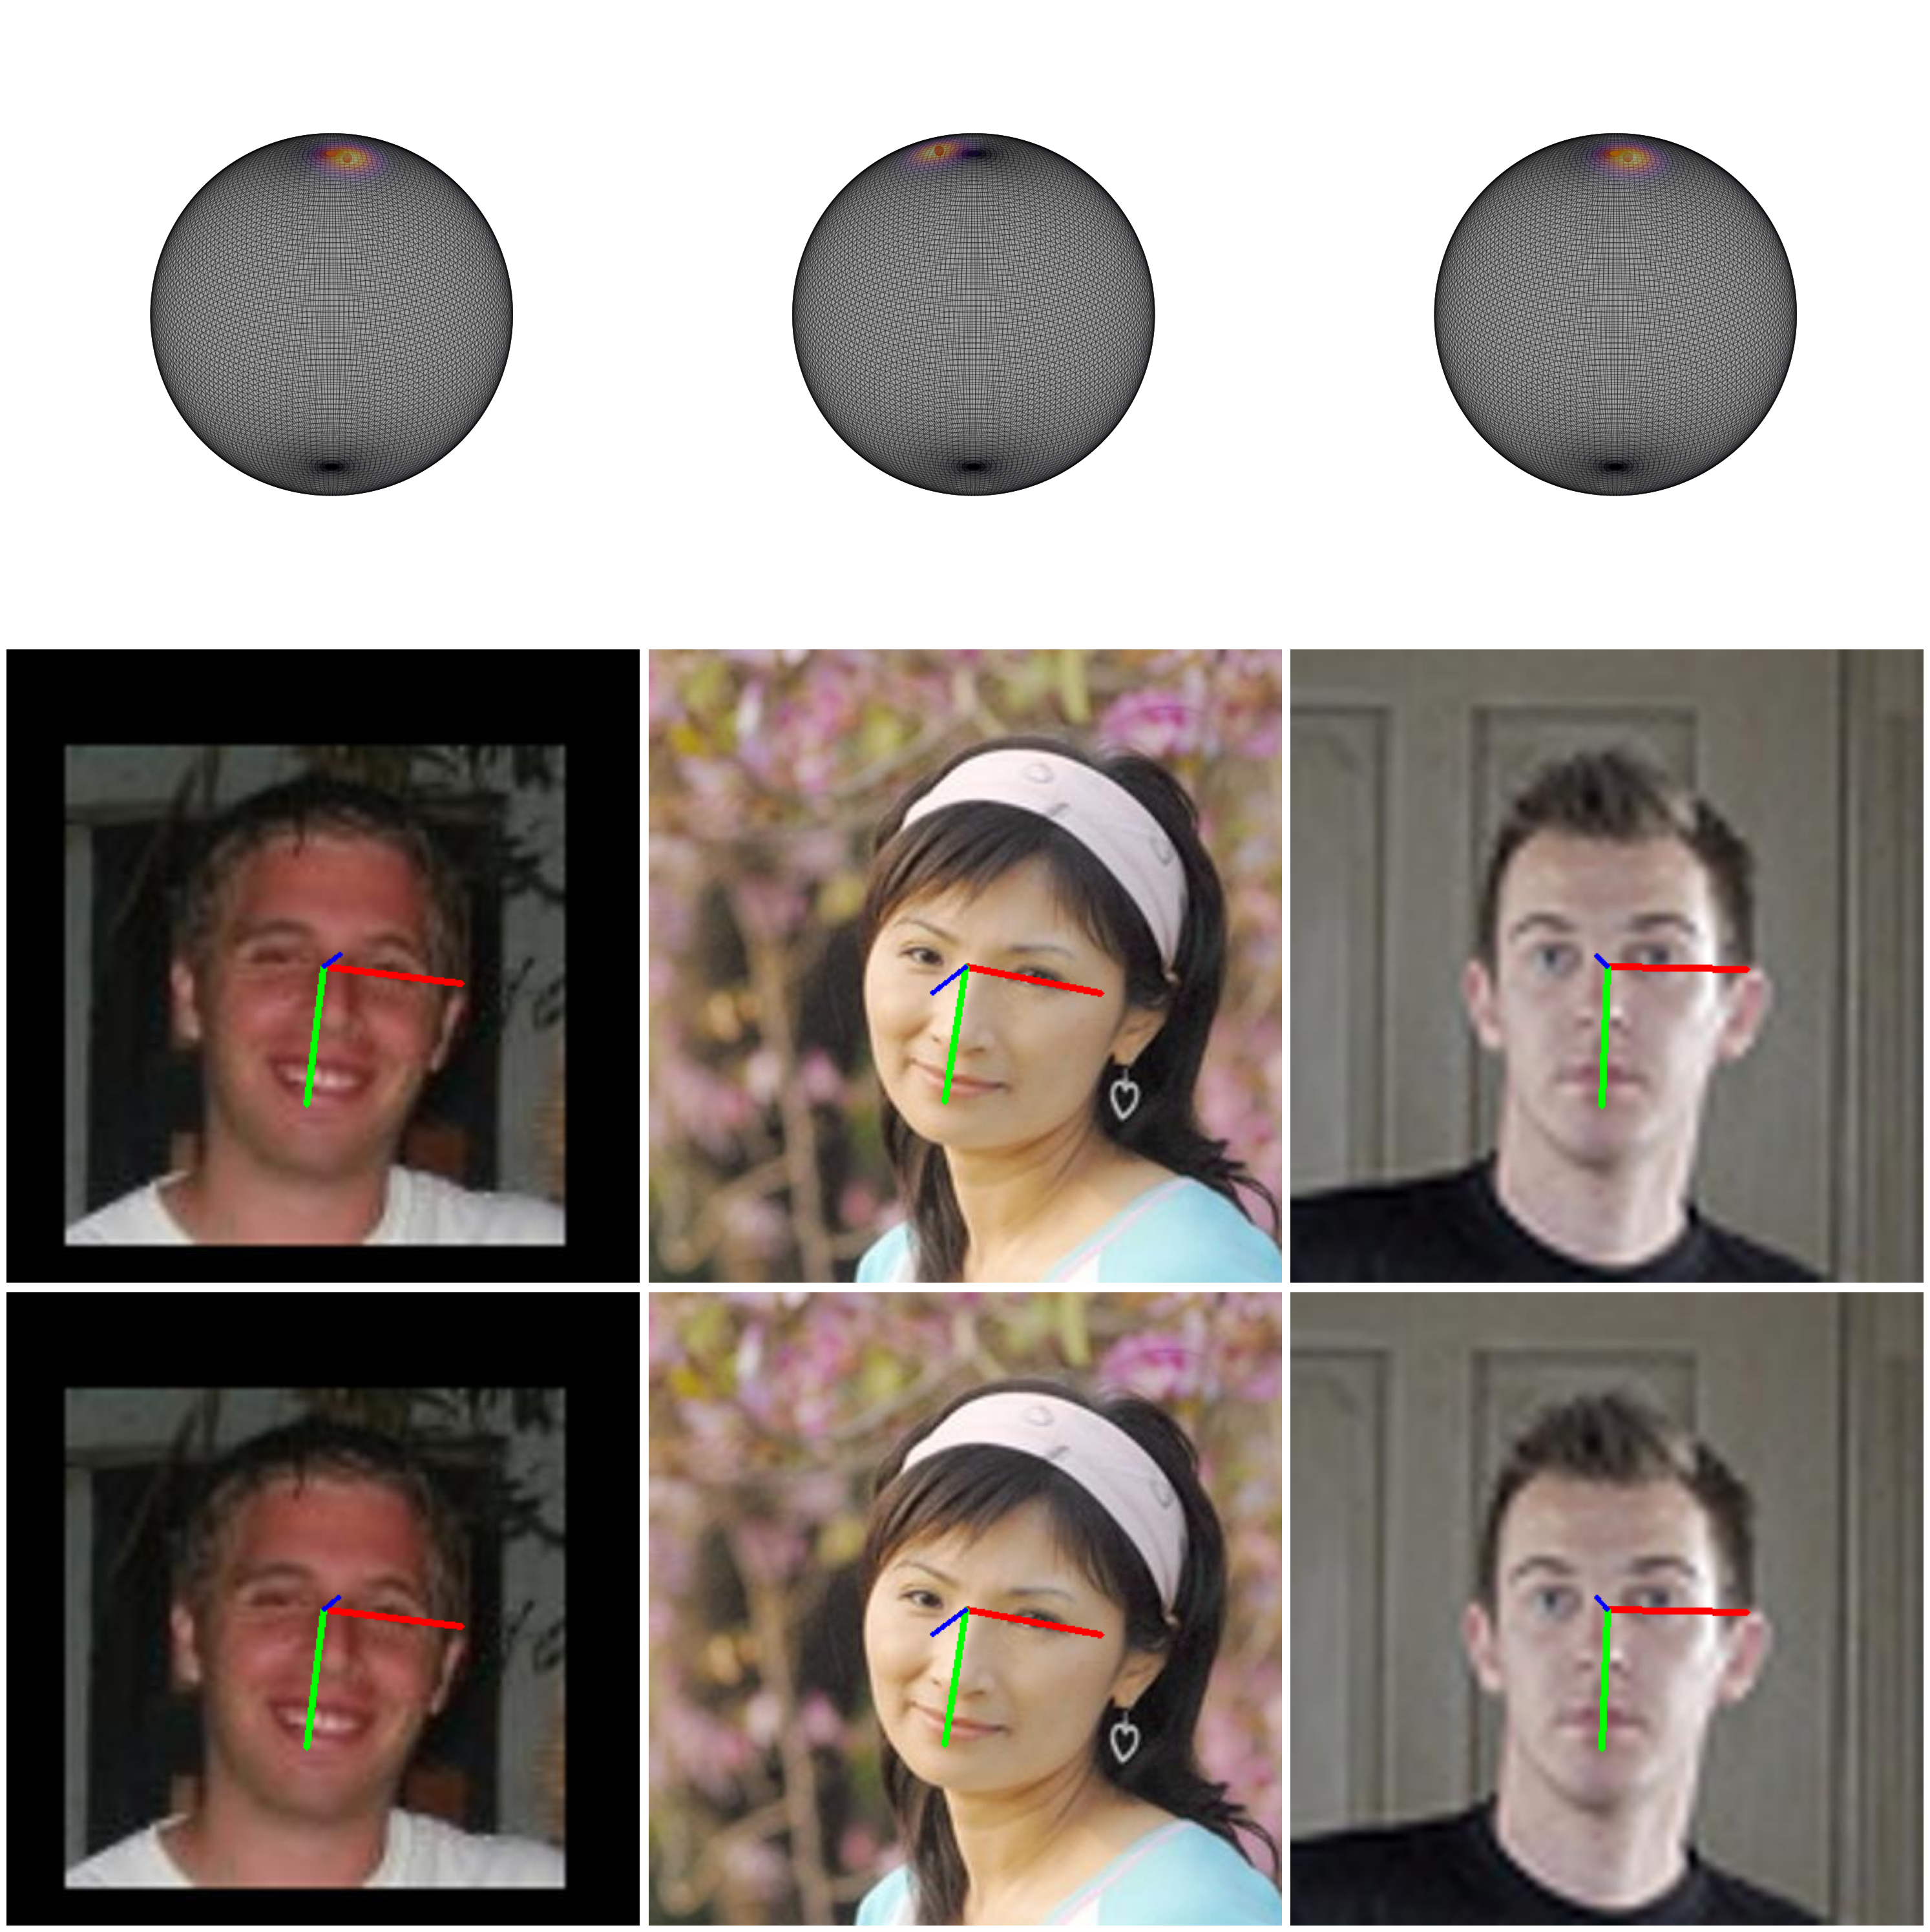

In [24]:
fig = plt.figure(figsize=(30,30))

ax = fig.add_subplot(331, projection='3d')
ax.plot_surface(X1_S2, X2_S2, X3_S2, rstride=1, cstride=1, color='cyan', alpha=0.2,
               facecolors=plt.cm.inferno(score_p1/jnp.amax(score_p1)))
ax.scatter(s1_train_euler[0,0], s1_train_euler[0,1], s1_train_euler[0,2], color='red', alpha=1.0, s=100)
ax.set_box_aspect([1,1,1])
ax.autoscale(False)
ax.set_xlim([-1.0,1.0])
ax.set_ylim([-1.0,1.0])
ax.set_zlim([-1.0,1.0])
ax.set_axis_off()

ax = fig.add_subplot(332, projection='3d')
ax.plot_surface(X1_S2, X2_S2, X3_S2, rstride=1, cstride=1, color='cyan', alpha=0.2,
               facecolors=plt.cm.inferno(score_p2/jnp.amax(score_p2)))
ax.scatter(s1_train_euler[1,0], s1_train_euler[1,1], s1_train_euler[1,2], color='red', alpha=1.0, s=100)
ax.set_box_aspect([1,1,1])
ax.autoscale(False)
ax.set_xlim([-1.0,1.0])
ax.set_ylim([-1.0,1.0])
ax.set_zlim([-1.0,1.0])
ax.set_axis_off()

ax = fig.add_subplot(333, projection='3d')
ax.plot_surface(X1_S2, X2_S2, X3_S2, rstride=1, cstride=1, color='cyan', alpha=0.2,
               facecolors=plt.cm.inferno(score_p3/jnp.amax(score_p3)))
ax.scatter(s1_train_euler[2,0], s1_train_euler[2,1], s1_train_euler[2,2], color='red', alpha=1.0, s=100)
ax.set_box_aspect([1,1,1])
ax.autoscale(False)
ax.set_xlim([-1.0,1.0])
ax.set_ylim([-1.0,1.0])
ax.set_zlim([-1.0,1.0])
ax.set_axis_off()

ax = fig.add_subplot(334)
ax.imshow(cv2.cvtColor(img1_true, cv2.COLOR_BGR2RGB))
ax.set_axis_off()

ax = fig.add_subplot(335)
ax.imshow(cv2.cvtColor(img2_true, cv2.COLOR_BGR2RGB))
ax.set_axis_off()

ax = fig.add_subplot(336)
ax.imshow(cv2.cvtColor(img3_true, cv2.COLOR_BGR2RGB))
ax.set_axis_off()

ax = fig.add_subplot(337)
ax.imshow(cv2.cvtColor(img1_trained, cv2.COLOR_BGR2RGB))
ax.set_axis_off()

ax = fig.add_subplot(338)
ax.imshow(cv2.cvtColor(img2_trained, cv2.COLOR_BGR2RGB))
ax.set_axis_off()

ax = fig.add_subplot(339)
ax.imshow(cv2.cvtColor(img3_trained, cv2.COLOR_BGR2RGB))
ax.set_axis_off()

fig.tight_layout()

plt.show()


### Plotting Testing Data

In [25]:
idx1 = 10
idx2 = 20
idx3 = 30

In [26]:
input_data = jnp.array(data_dict['test_features'])
output_data = jnp.array(data_dict['test_labels'])

f_train, sigma_train = mlnr_fun(input_data)
_, _, s1p_fun = load_score_model("Sphere", 2)

using M.Exp for Logarithm


In [27]:
f_train_euler = toEulerAngles(f_train[:,0], f_train[:,1], f_train[:,2], f_train[:,3])
train_euler = toEulerAngles(jnp.array(data_dict['test_labels'])[:,0], 
                            jnp.array(data_dict['test_labels'])[:,1], 
                            jnp.array(data_dict['test_labels'])[:,2], 
                            jnp.array(data_dict['test_labels'])[:,3])

In [28]:
s1_train_euler = to_sphere(train_euler[:,1], train_euler[:,0])
s2_train_euler = to_sphere(train_euler[:,1], train_euler[:,2])
s3_train_euler = to_sphere(train_euler[:,0], train_euler[:,2])

s1_f_train_euler = to_sphere(f_train_euler[:,0], f_train_euler[:,1])
s2_f_train_euler = to_sphere(f_train_euler[:,0], f_train_euler[:,2])
s3_f_train_euler = to_sphere(f_train_euler[:,1], f_train_euler[:,2])

In [29]:
img = data_dict['test_original_images']

img1_true = draw_axis(np.array(img)[idx1], train_euler[idx1,1], train_euler[idx1,2], train_euler[idx1,0])
img1_trained = draw_axis(np.array(img)[idx1], f_train_euler[idx1,1], f_train_euler[idx1,2], f_train_euler[idx1,0])

img2_true = draw_axis(np.array(img)[idx2], train_euler[idx2,1], train_euler[idx2,2], train_euler[idx2,0])
img2_trained = draw_axis(np.array(img)[idx2], f_train_euler[idx2,1], f_train_euler[idx2,2], f_train_euler[idx2,0])

img3_true = draw_axis(np.array(img)[idx3], train_euler[idx3,1], train_euler[idx3,2], train_euler[idx3,0])
img3_trained = draw_axis(np.array(img)[idx3], f_train_euler[idx3,1], f_train_euler[idx3,2], f_train_euler[idx3,0])

In [77]:
# Creating the theta and phi values.
intervals = 100

theta = jnp.linspace(0.0, jnp.pi*1, intervals)
phi   = jnp.linspace(0.0, jnp.pi*2, intervals)

# Creating the coordinate grid for the unit sphere.
X1_S2 = jnp.outer(jnp.sin(theta), jnp.cos(phi))
X2_S2 = jnp.outer(jnp.sin(theta), jnp.sin(phi))
X3_S2 = jnp.outer(jnp.cos(theta), jnp.ones(intervals))

X_heat = jnp.transpose(jnp.concatenate((X1_S2.reshape(1, intervals, intervals), 
                     X2_S2.reshape(1, intervals, intervals), 
                     X3_S2.reshape(1, intervals, intervals))), axes=(1,2,0))

In [78]:
S2, _, s1p_fun = load_score_model("Sphere", 2)

using M.Exp for Logarithm


In [79]:
numerical_grad = lambda y: s1p_fun(get_coords(S2,s1_train_euler[idx1]), get_coords(S2,y), sigma_train[idx1]**2)
score_log_p1 = vmap(lambda x2: vmap(lambda x1: numerical_grad(x1))(x2))(X_heat)

numerical_grad = lambda y: s1p_fun(get_coords(S2,s1_train_euler[idx2]), get_coords(S2,y), sigma_train[idx2]**2)
score_log_p2 = vmap(lambda x2: vmap(lambda x1: numerical_grad(x1))(x2))(X_heat)

numerical_grad = lambda y: s1p_fun(get_coords(S2,s1_train_euler[idx3]), get_coords(S2,y), sigma_train[idx3]**2)
score_log_p3 = vmap(lambda x2: vmap(lambda x1: numerical_grad(x1))(x2))(X_heat)

score_p1 = jnp.exp(score_log_p1)
score_p1 /= jnp.max(score_p1)

score_p2 = jnp.exp(score_log_p2)
score_p2 /= jnp.max(score_p2)

score_p3 = jnp.exp(score_log_p3)
score_p3 /= jnp.max(score_p3)

In [80]:
score_sum = score_p1+score_p2+score_p3

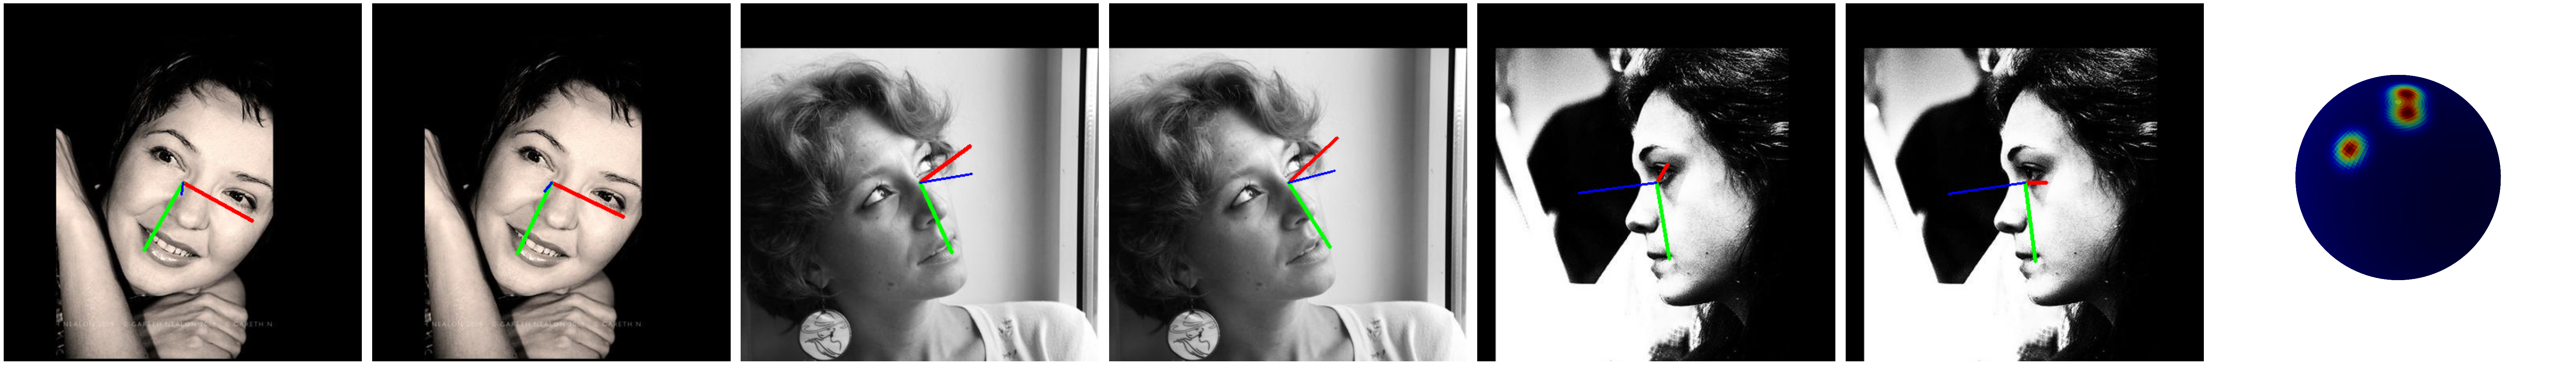

In [87]:
fig = plt.figure(figsize=(70,10))

ax = fig.add_subplot(171)
ax.imshow(cv2.cvtColor(img1_true, cv2.COLOR_BGR2RGB))
ax.set_axis_off()

ax = fig.add_subplot(172)
ax.imshow(cv2.cvtColor(img1_trained, cv2.COLOR_BGR2RGB))
ax.set_axis_off()

ax = fig.add_subplot(173)
ax.imshow(cv2.cvtColor(img2_true, cv2.COLOR_BGR2RGB))
ax.set_axis_off()

ax = fig.add_subplot(174)
ax.imshow(cv2.cvtColor(img2_trained, cv2.COLOR_BGR2RGB))
ax.set_axis_off()

ax = fig.add_subplot(175)
ax.imshow(cv2.cvtColor(img3_true, cv2.COLOR_BGR2RGB))
ax.set_axis_off()

ax = fig.add_subplot(176)
ax.imshow(cv2.cvtColor(img3_trained, cv2.COLOR_BGR2RGB))
ax.set_axis_off()

ax = fig.add_subplot(177, projection='3d')
ax.plot_surface(X1_S2, X2_S2, X3_S2, rstride=1, cstride=1, color='cyan', alpha=1.0,
               facecolors=plt.cm.jet(score_sum))
ax.scatter(s1_train_euler[idx1,0], s1_train_euler[idx1,1], s1_train_euler[idx1,2], color='red', alpha=1.0, s=100)
ax.scatter(s1_train_euler[idx2,0], s1_train_euler[idx2,1], s1_train_euler[idx2,2], color='red', alpha=1.0, s=100)
ax.scatter(s1_train_euler[idx3,0], s1_train_euler[idx3,1], s1_train_euler[idx3,2], color='red', alpha=1.0, s=100)
#ax.text(s1_train_euler[idx1,0],s1_train_euler[idx1,1],s1_train_euler[idx1,2],  '1', size=100, zorder=1,  
#    color='red', ha='left')
#ax.text(s1_train_euler[idx2,0],s1_train_euler[idx2,1],s1_train_euler[idx2,2],  '2', size=100, zorder=1,  
#    color='red', ha='left')
#ax.text(s1_train_euler[idx3,0],s1_train_euler[idx3,1],s1_train_euler[idx3,2],  '3', size=100, zorder=1,  
#    color='red', ha='left')
ax.set_box_aspect([1,1,1])
ax.autoscale(False)
ax.set_xlim([-1.0,1.0])
ax.set_ylim([-1.0,1.0])
ax.set_zlim([-1.0,1.0])
ax.set_axis_off()
ax.grid(False)
ax.view_init(elev=45., azim=180)

fig.tight_layout()

fig.savefig(f'{figure_path}head_pose_s3.pdf', format='pdf', pad_inches=0.1, bbox_inches='tight')

plt.show()
